# FINM RL Trading - Main Analysis Notebook

This notebook provides comprehensive analysis of all experimental results:
- Core baselines comparison (PPO vs BuyAndHold vs MACrossover)
- Hyperparameter sensitivity analysis
- State/Environment ablation studies
- Regime-based performance analysis
- Reward shaping analysis
- Robustness testing results
- Summary dashboard


In [2]:
# Setup: Paths and Imports
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, List

# Set up paths
CURRENT_DIR = Path().resolve()
PROJECT_ROOT = CURRENT_DIR.parent
RESULTS_DIR = PROJECT_ROOT / "results"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT = {PROJECT_ROOT}")
print(f"RESULTS_DIR = {RESULTS_DIR}")
print(f"Results available: {list(RESULTS_DIR.iterdir()) if RESULTS_DIR.exists() else 'Not found'}")


PROJECT_ROOT = /Users/nickdonato/finm-rl-project
RESULTS_DIR = /Users/nickdonato/finm-rl-project/results
Results available: [PosixPath('/Users/nickdonato/finm-rl-project/results/pretrain_ma_bc'), PosixPath('/Users/nickdonato/finm-rl-project/results/core_baselines')]


In [3]:
# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [4]:
# Export utilities
def export_table_csv(df: pd.DataFrame, path: Path) -> None:
    """Export DataFrame to CSV."""
    df.to_csv(path, index=False)
    print(f"Exported table to {path}")

def export_table_latex(df: pd.DataFrame, path: Path, **kwargs) -> None:
    """Export DataFrame to LaTeX format."""
    latex_str = df.to_latex(index=False, **kwargs)
    with open(path, 'w') as f:
        f.write(latex_str)
    print(f"Exported LaTeX table to {path}")

def export_table_html(df: pd.DataFrame, path: Path, **kwargs) -> None:
    """Export DataFrame to HTML format."""
    html_str = df.to_html(index=False, **kwargs)
    with open(path, 'w') as f:
        f.write(html_str)
    print(f"Exported HTML table to {path}")

# Create exports directory
EXPORTS_DIR = PROJECT_ROOT / "notebooks" / "exports"
EXPORTS_DIR.mkdir(exist_ok=True)
print(f"Export directory: {EXPORTS_DIR}")


Export directory: /Users/nickdonato/finm-rl-project/notebooks/exports


## 1. Core Baselines Comparison

Compare PPO performance against simple baselines: BuyAndHold and MACrossover.


In [5]:
# Load core baselines metrics
core_baselines_path = RESULTS_DIR / "core_baselines" / "core_metrics.json"
with open(core_baselines_path, 'r') as f:
    core_metrics = json.load(f)

# Convert to DataFrame for easier analysis
baselines_data = []
for strategy, metrics in core_metrics.items():
    row = {"strategy": strategy}
    row.update(metrics)
    baselines_data.append(row)

baselines_df = pd.DataFrame(baselines_data)
print("Core Baselines Comparison:")
print(baselines_df.to_string(index=False))


Core Baselines Comparison:
   strategy  total_return  annualized_return   sharpe  max_drawdown
        PPO      0.422840           0.097417 0.464259      0.225549
 BuyAndHold      0.392219           0.091141 0.395578      0.337173
MACrossover      0.288678           0.069138 0.524672      0.288871


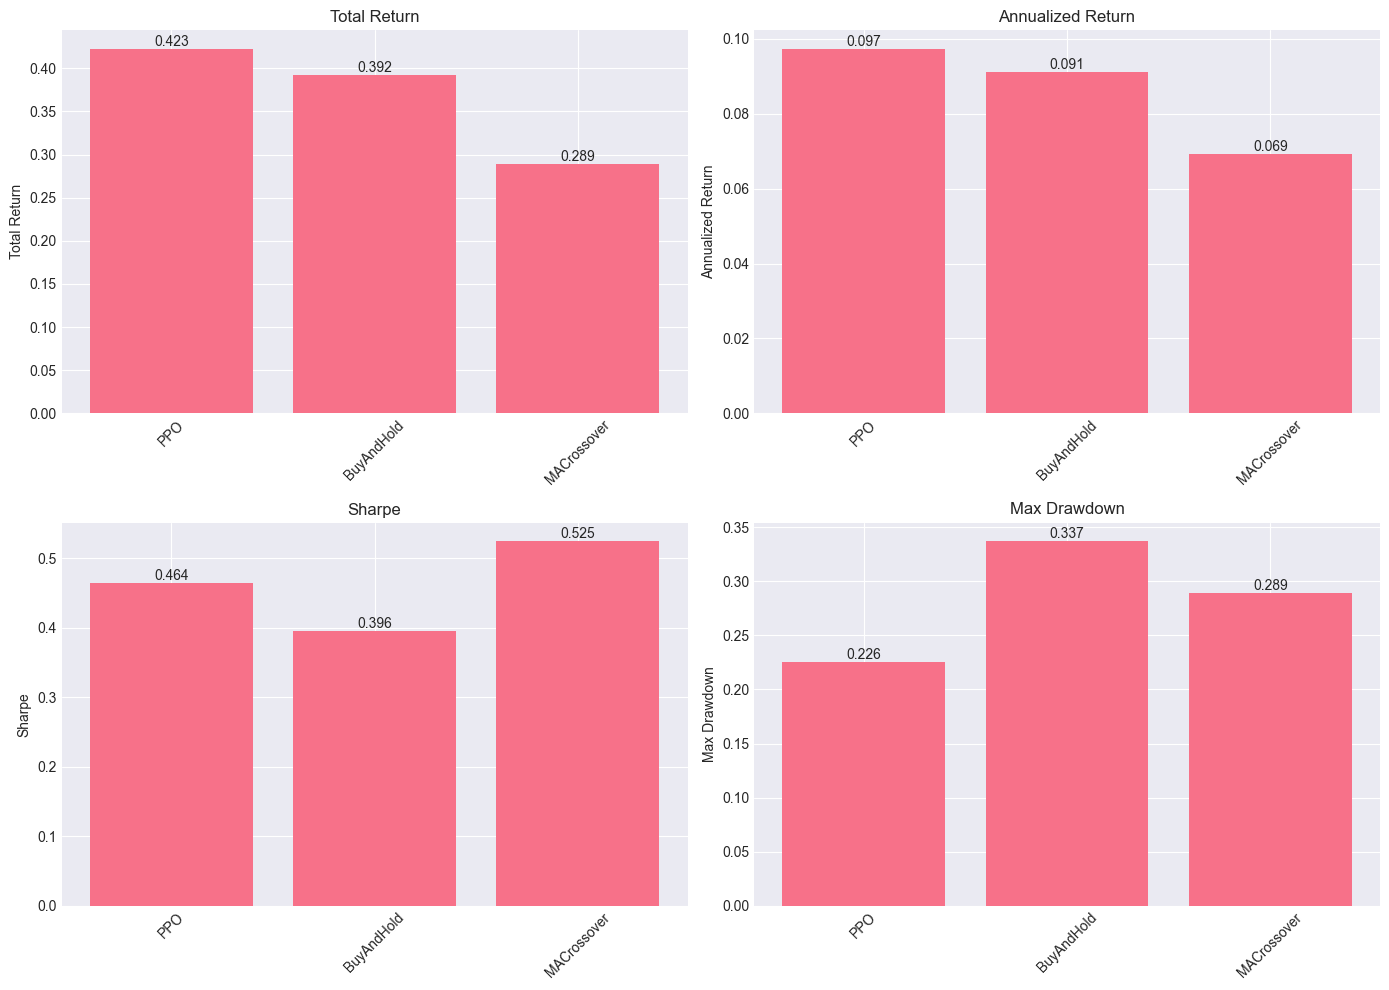

Saved baselines comparison plot to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.png


In [6]:
# Visualize baselines comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(baselines_df['strategy'], baselines_df[metric])
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(EXPORTS_DIR / "baselines_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved baselines comparison plot to {EXPORTS_DIR / 'baselines_comparison.png'}")


In [7]:
# Export baselines comparison table
export_table_csv(baselines_df, EXPORTS_DIR / "baselines_comparison.csv")
export_table_latex(baselines_df, EXPORTS_DIR / "baselines_comparison.tex", float_format="%.4f")
export_table_html(baselines_df, EXPORTS_DIR / "baselines_comparison.html", classes='table table-striped')

Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.tex
Exported HTML table to /Users/nickdonato/finm-rl-project/notebooks/exports/baselines_comparison.html


## 2. Summary Dashboard


In [9]:
# Load hyperparameter results
hyperparams_dir = RESULTS_DIR / "ppo_hyperparams"
hyperparams_summary_path = hyperparams_dir / "summary_test_metrics.csv"

if hyperparams_summary_path.exists():
    hyperparams_df = pd.read_csv(hyperparams_summary_path)
    print("Hyperparameter Summary:")
    print(hyperparams_df.to_string(index=False))
    
    # Load individual run JSONs to extract config details
    run_configs = []
    for json_file in hyperparams_dir.glob("*.json"):
        if json_file.name != "summary_test_metrics.json":
            with open(json_file, 'r') as f:
                run_data = json.load(f)
                if 'config' in run_data:
                    config = run_data['config']
                    name = run_data.get('name', json_file.stem)
                    metrics = run_data.get('test_metrics', {})
                    run_configs.append({
                        'name': name,
                        'clip_epsilon': config.get('clip_epsilon', None),
                        'entropy_coef': config.get('entropy_coef', None),
                        'gamma': config.get('gamma', None),
                        'gae_lambda': config.get('gae_lambda', None),
                        **metrics
                    })
    
    if run_configs:
        hyperparams_detailed_df = pd.DataFrame(run_configs)
        print("\nDetailed Hyperparameter Configurations:")
        print(hyperparams_detailed_df.to_string(index=False))
else:
    print("Hyperparameter results not found")
    hyperparams_df = None
    hyperparams_detailed_df = None


Hyperparameter Summary:
                name  total_return  annualized_return    sharpe  max_drawdown
     clip0.1_ent0.00     -0.306279          -0.087616 -0.473425      0.353015
     clip0.2_ent0.01      0.423653           0.092611  0.603275      0.168048
     clip0.3_ent0.01      0.112632           0.027123  0.132882      0.279373
gamma0.95_lambda0.90     -0.298170          -0.084953 -0.634158      0.433932

Detailed Hyperparameter Configurations:
                name clip_epsilon  entropy_coef  gamma  gae_lambda  total_return  annualized_return    sharpe  max_drawdown
     clip0.1_ent0.00         None          0.00   0.99        0.95     -0.306279          -0.087616 -0.473425      0.353015
gamma0.95_lambda0.90         None          0.01   0.95        0.90     -0.298170          -0.084953 -0.634158      0.433932
     clip0.2_ent0.01         None          0.01   0.99        0.95      0.423653           0.092611  0.603275      0.168048
     clip0.3_ent0.01         None          0.01  

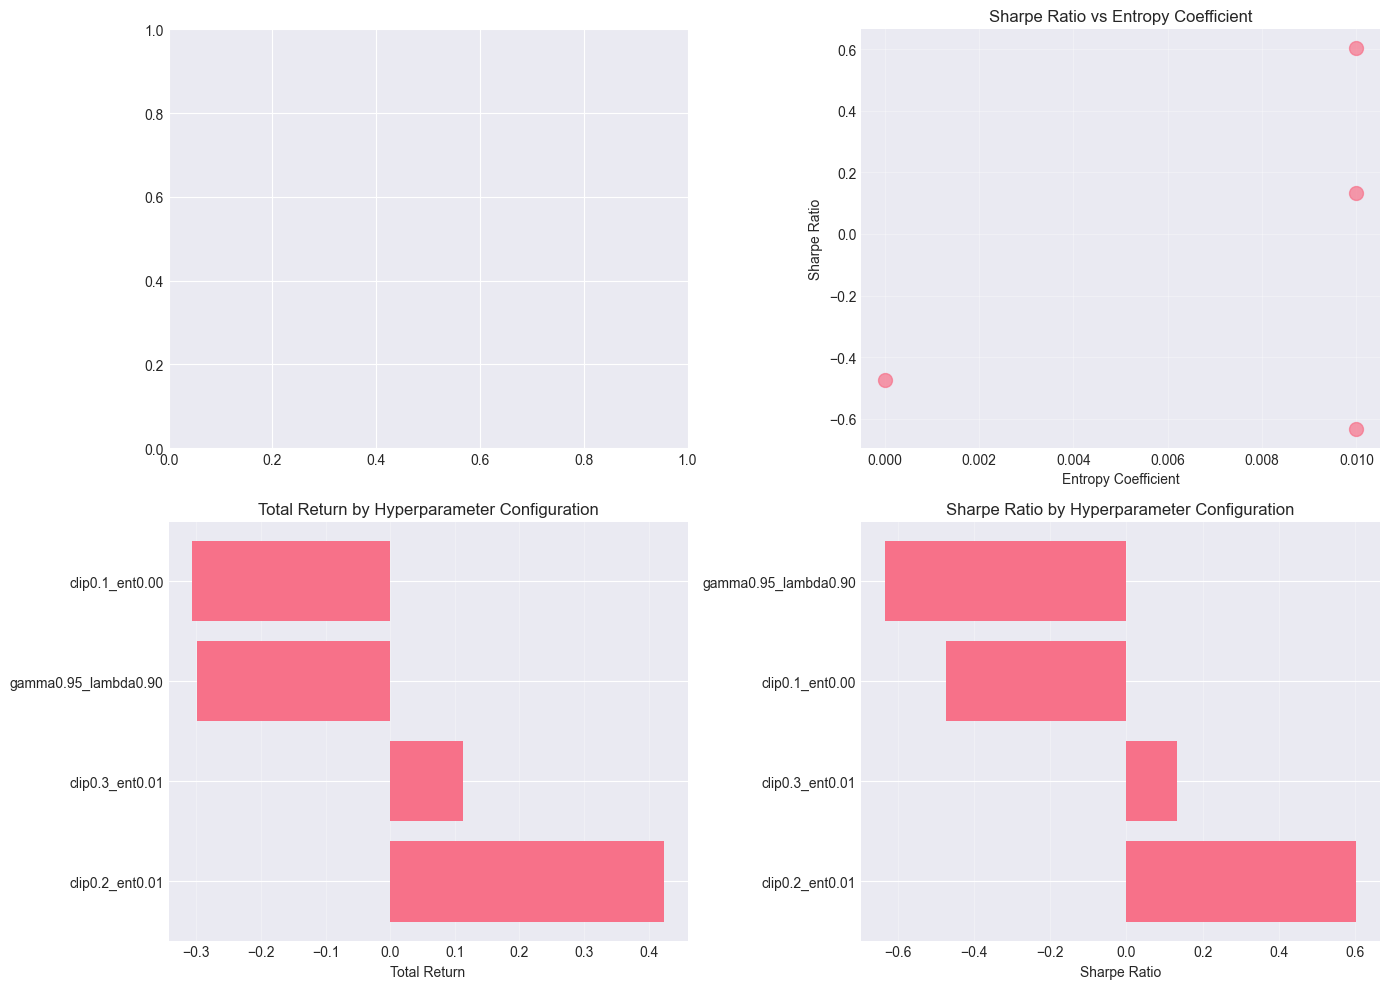

Saved hyperparameter sensitivity plot to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_sensitivity.png

Best Configuration (by Sharpe):
name                 clip0.2_ent0.01
total_return                0.423653
annualized_return           0.092611
sharpe                      0.603275
max_drawdown                0.168048
Name: 1, dtype: object

Worst Configuration (by Sharpe):
name                 gamma0.95_lambda0.90
total_return                     -0.29817
annualized_return               -0.084953
sharpe                          -0.634158
max_drawdown                     0.433932
Name: 3, dtype: object


In [10]:
# Create hyperparameter sensitivity plots
if hyperparams_df is not None and hyperparams_detailed_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Sharpe vs Clip Epsilon
    if 'clip_epsilon' in hyperparams_detailed_df.columns:
        ax = axes[0, 0]
        clip_data = hyperparams_detailed_df[hyperparams_detailed_df['clip_epsilon'].notna()]
        if not clip_data.empty:
            ax.scatter(clip_data['clip_epsilon'], clip_data['sharpe'], s=100, alpha=0.7)
            ax.set_xlabel('Clip Epsilon')
            ax.set_ylabel('Sharpe Ratio')
            ax.set_title('Sharpe Ratio vs Clip Epsilon')
            ax.grid(True, alpha=0.3)
    
    # Plot 2: Sharpe vs Entropy Coefficient
    if 'entropy_coef' in hyperparams_detailed_df.columns:
        ax = axes[0, 1]
        ent_data = hyperparams_detailed_df[hyperparams_detailed_df['entropy_coef'].notna()]
        if not ent_data.empty:
            ax.scatter(ent_data['entropy_coef'], ent_data['sharpe'], s=100, alpha=0.7)
            ax.set_xlabel('Entropy Coefficient')
            ax.set_ylabel('Sharpe Ratio')
            ax.set_title('Sharpe Ratio vs Entropy Coefficient')
            ax.grid(True, alpha=0.3)
    
    # Plot 3: Total Return by Configuration
    ax = axes[1, 0]
    hyperparams_df_sorted = hyperparams_df.sort_values('total_return', ascending=False)
    bars = ax.barh(hyperparams_df_sorted['name'], hyperparams_df_sorted['total_return'])
    ax.set_xlabel('Total Return')
    ax.set_title('Total Return by Hyperparameter Configuration')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Sharpe by Configuration
    ax = axes[1, 1]
    hyperparams_df_sorted_sharpe = hyperparams_df.sort_values('sharpe', ascending=False)
    bars = ax.barh(hyperparams_df_sorted_sharpe['name'], hyperparams_df_sorted_sharpe['sharpe'])
    ax.set_xlabel('Sharpe Ratio')
    ax.set_title('Sharpe Ratio by Hyperparameter Configuration')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "hyperparams_sensitivity.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved hyperparameter sensitivity plot to {EXPORTS_DIR / 'hyperparams_sensitivity.png'}")
    
    # Highlight best/worst
    print("\nBest Configuration (by Sharpe):")
    best_sharpe = hyperparams_df.loc[hyperparams_df['sharpe'].idxmax()]
    print(best_sharpe)
    
    print("\nWorst Configuration (by Sharpe):")
    worst_sharpe = hyperparams_df.loc[hyperparams_df['sharpe'].idxmin()]
    print(worst_sharpe)


In [11]:
# Export hyperparameter tables
if hyperparams_df is not None:
    export_table_csv(hyperparams_df, EXPORTS_DIR / "hyperparams_summary.csv")
    export_table_latex(hyperparams_df, EXPORTS_DIR / "hyperparams_summary.tex", float_format="%.4f")
    
if hyperparams_detailed_df is not None:
    export_table_csv(hyperparams_detailed_df, EXPORTS_DIR / "hyperparams_detailed.csv")


Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_summary.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_summary.tex
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/hyperparams_detailed.csv


## 3. State/Environment Ablation Analysis

Compare performance across different state representations and environment configurations.


State/Environment Ablation Results:
       config  total_return  annualized_return    sharpe  max_drawdown
  single_rich     -0.096115          -0.025020 -0.139961      0.309157
single_simple      0.460031           0.099545  0.585256      0.306432
 pairs_simple     -0.137138          -0.036345 -0.500432      0.209568


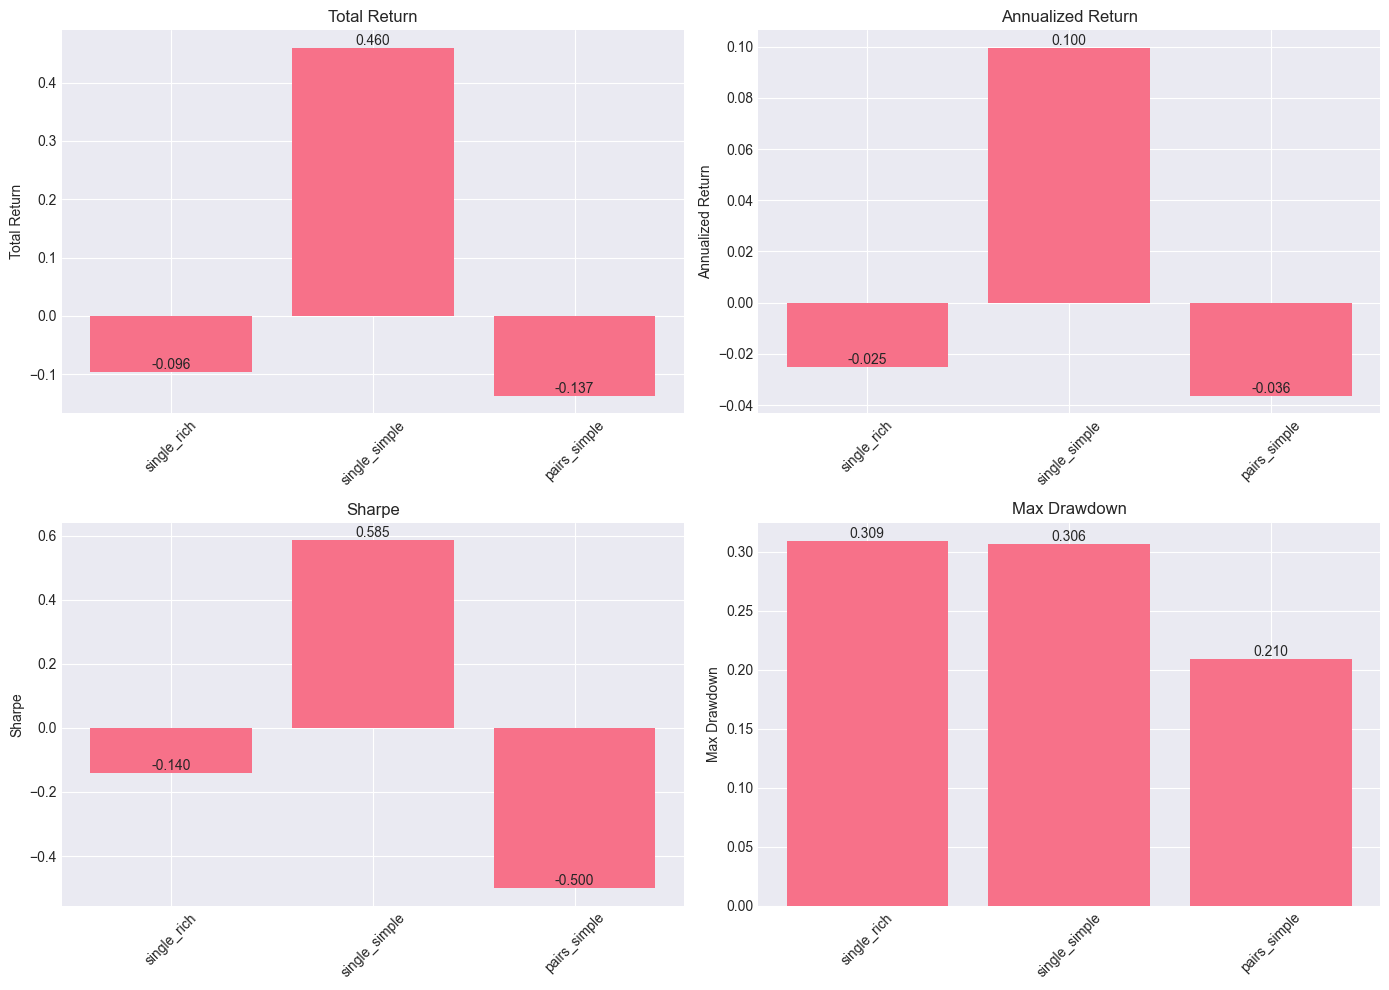

Saved state/env comparison plot to /Users/nickdonato/finm-rl-project/notebooks/exports/states_envs_comparison.png
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/states_envs_comparison.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/states_envs_comparison.tex


In [12]:
# Load state/env ablation results
states_envs_dir = RESULTS_DIR / "states_envs"
states_envs_data = []

for json_file in states_envs_dir.glob("*_metrics.json"):
    with open(json_file, 'r') as f:
        metrics = json.load(f)
        name = json_file.stem.replace("_metrics", "")
        row = {"config": name}
        # Remove shaping_config if present
        if 'shaping_config' in metrics:
            del metrics['shaping_config']
        row.update(metrics)
        states_envs_data.append(row)

if states_envs_data:
    states_envs_df = pd.DataFrame(states_envs_data)
    print("State/Environment Ablation Results:")
    print(states_envs_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(states_envs_df['config'], states_envs_df[metric])
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "states_envs_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved state/env comparison plot to {EXPORTS_DIR / 'states_envs_comparison.png'}")
    
    # Export table
    export_table_csv(states_envs_df, EXPORTS_DIR / "states_envs_comparison.csv")
    export_table_latex(states_envs_df, EXPORTS_DIR / "states_envs_comparison.tex", float_format="%.4f")
else:
    print("State/Environment results not found")
    states_envs_df = None


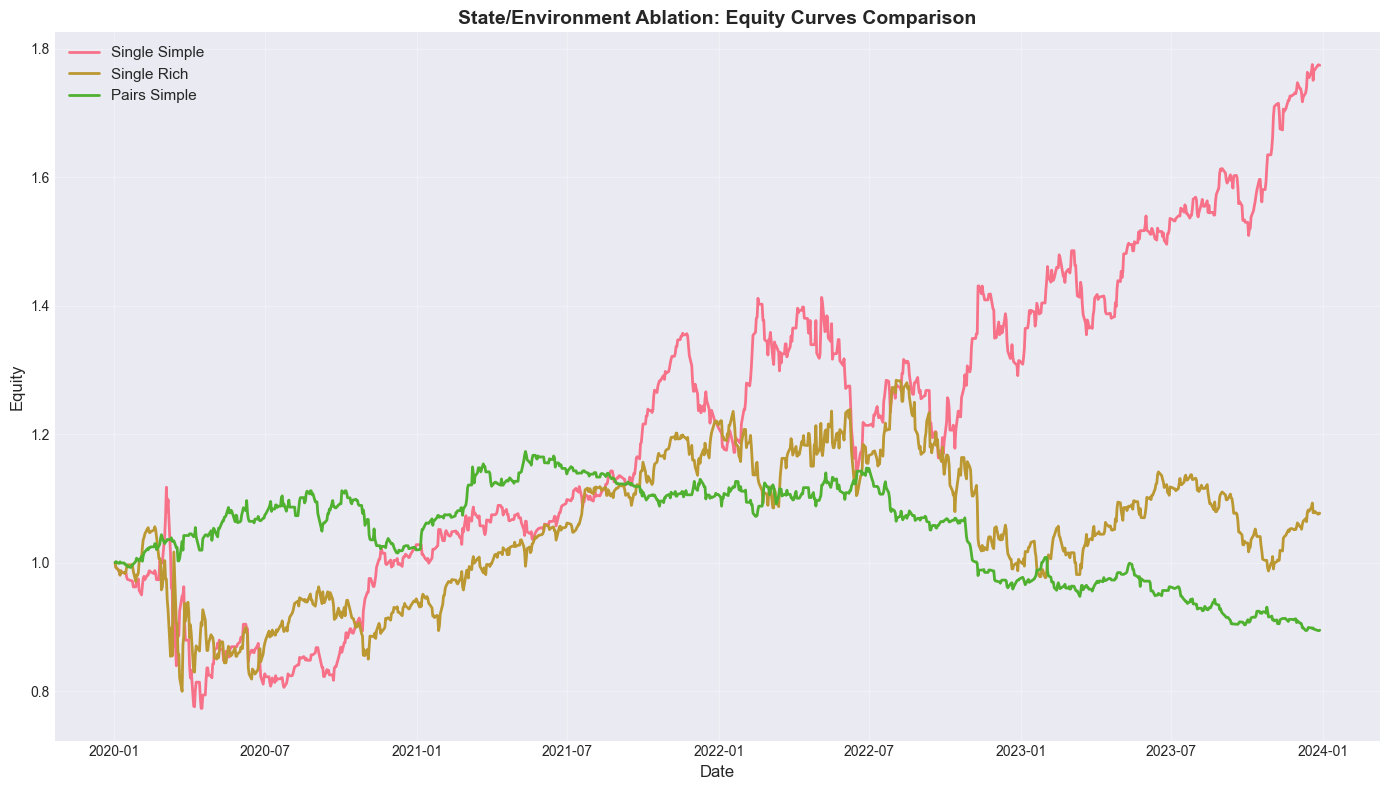

Saved combined equity curves plot to /Users/nickdonato/finm-rl-project/notebooks/exports/states_envs_equity_curves.png


In [14]:
# Plot all 3 equity curves together
if states_envs_data:
    from eval.plotting import plot_equity_curves
    import pandas as pd
    
    # Load equity curves from JSON files
    equity_curves = {}
    dates_list = None
    
    for config_name in ['single_simple', 'single_rich', 'pairs_simple']:
        equity_json_path = states_envs_dir / f"{config_name}_equity.json"
        if equity_json_path.exists():
            with open(equity_json_path, 'r') as f:
                equity_data = json.load(f)
                equity_curves[config_name] = np.array(equity_data['equity'])
                # Use dates from first available config
                if dates_list is None and 'dates' in equity_data:
                    dates_list = pd.to_datetime(equity_data['dates'])
    
    if equity_curves:
        # Align all curves to minimum length
        min_len = min(len(eq) for eq in equity_curves.values())
        aligned_curves = {name: eq[:min_len] for name, eq in equity_curves.items()}
        if dates_list is not None:
            aligned_dates = dates_list[:min_len]
        else:
            aligned_dates = None
        
        # Create combined plot
        fig, ax = plt.subplots(figsize=(14, 8))
        for name, eq in aligned_curves.items():
            label = name.replace('_', ' ').title()
            ax.plot(aligned_dates if aligned_dates is not None else range(len(eq)), eq, label=label, linewidth=2)
        
        ax.set_xlabel('Date' if aligned_dates is not None else 'Time', fontsize=12)
        ax.set_ylabel('Equity', fontsize=12)
        ax.set_title('State/Environment Ablation: Equity Curves Comparison', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        
        output_path = EXPORTS_DIR / "states_envs_equity_curves.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved combined equity curves plot to {output_path}")
    else:
        print("Equity curve JSON files not found. Re-run exp_states_envs.py to generate them.")


## 4. Regime Analysis

Analyze PPO performance across different market regimes: Bull/Bear and Volatility regimes.


In [15]:
# Load regime comparison data
regime_dir = RESULTS_DIR / "regimes"
regime_comparison_path = regime_dir / "regime_comparison.csv"
regime_metrics_path = regime_dir / "regime_metrics.json"

if regime_comparison_path.exists():
    regime_df = pd.read_csv(regime_comparison_path)
    print("Regime Comparison Data:")
    print(regime_df.to_string(index=False))
else:
    print("Regime comparison CSV not found")
    regime_df = None

# Also load JSON for additional details
if regime_metrics_path.exists():
    with open(regime_metrics_path, 'r') as f:
        regime_metrics_json = json.load(f)
    print("\nRegime Metrics (JSON):")
    print(json.dumps(regime_metrics_json, indent=2))
else:
    print("Regime metrics JSON not found")
    regime_metrics_json = None


Regime Comparison Data:
regime_type regime_label  total_return  annualized_return   sharpe  max_drawdown  count
  bull_bear         bear      0.244476           0.209316 0.943773      0.179224    290
  bull_bear         bull      0.289590           0.093776 1.034820      0.057106    715
 volatility     high_vol      0.171254           0.140998 0.659431      0.122872    302
 volatility      low_vol      0.370210           0.119524 1.258815      0.091537    703

Regime Metrics (JSON):
{
  "bull_bear": {
    "bear": {
      "total_return": 0.24447562808296985,
      "annualized_return": 0.2093162885724904,
      "sharpe": 0.9437726694347159,
      "max_drawdown": 0.17922417788632505,
      "count": 290
    },
    "bull": {
      "total_return": 0.2895902717357135,
      "annualized_return": 0.09377614768854947,
      "sharpe": 1.0348196020119211,
      "max_drawdown": 0.05710578084162932,
      "count": 715
    }
  },
  "volatility": {
    "high_vol": {
      "total_return": 0.17125368448

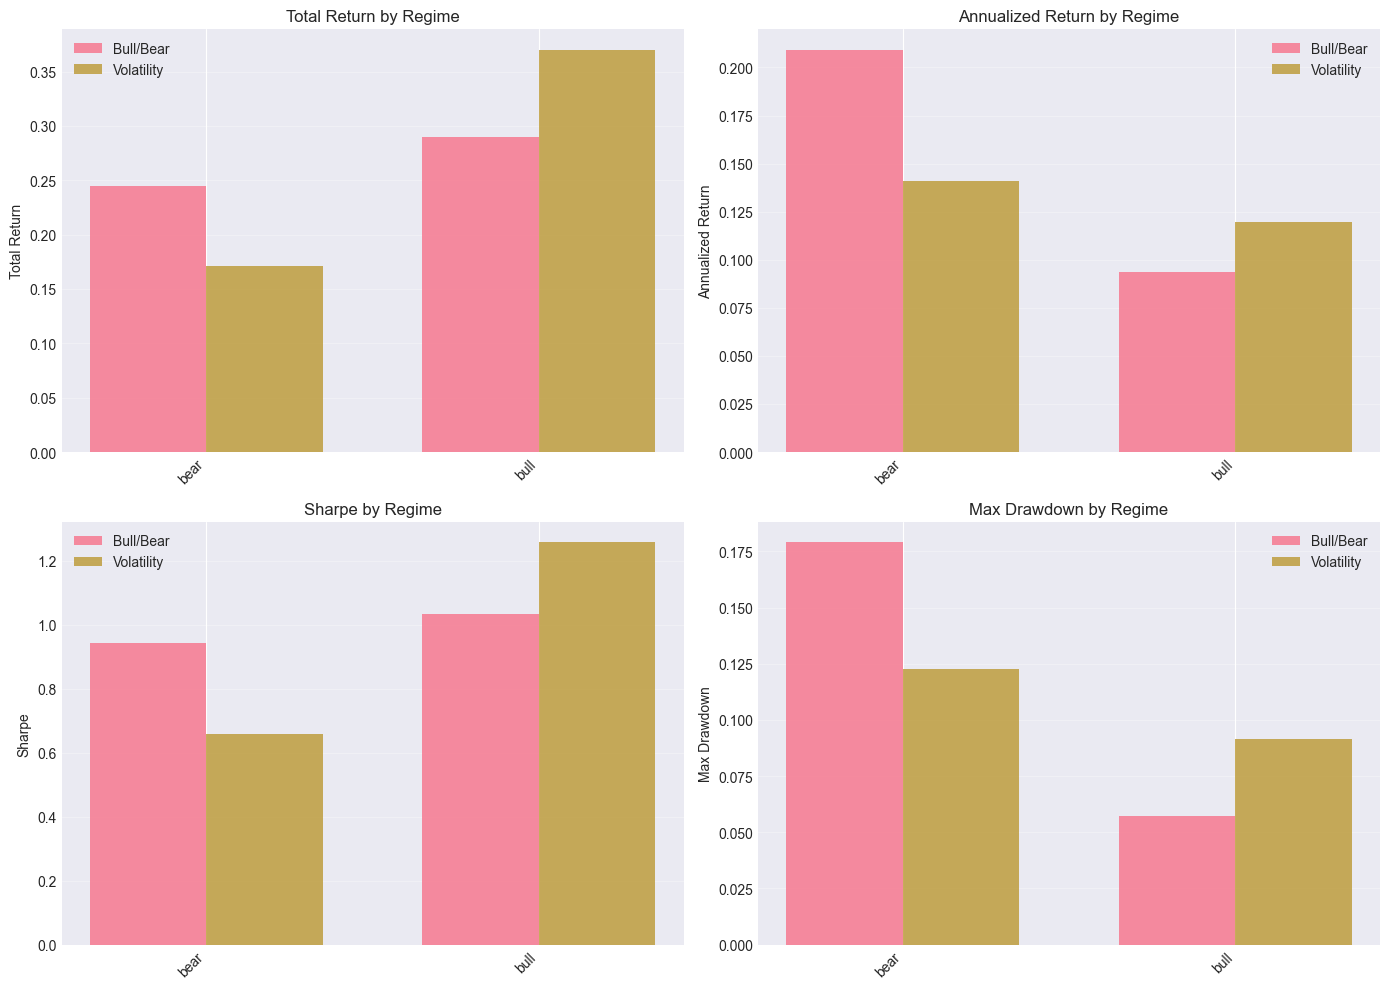

Saved regime performance plot to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_performance.png


In [16]:
# Visualize regime performance with bar charts
if regime_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        # Separate by regime type
        bull_bear_data = regime_df[regime_df['regime_type'] == 'bull_bear']
        vol_data = regime_df[regime_df['regime_type'] == 'volatility']
        
        x = np.arange(max(len(bull_bear_data), len(vol_data)))
        width = 0.35
        
        if not bull_bear_data.empty:
            ax.bar(x[:len(bull_bear_data)] - width/2, bull_bear_data[metric], 
                   width, label='Bull/Bear', alpha=0.8)
        if not vol_data.empty:
            ax.bar(x[:len(vol_data)] + width/2, vol_data[metric], 
                   width, label='Volatility', alpha=0.8)
        
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.set_title(f'{metric.replace("_", " ").title()} by Regime')
        ax.set_xticks(x[:max(len(bull_bear_data), len(vol_data))])
        if not bull_bear_data.empty:
            labels = list(bull_bear_data['regime_label']) + [''] * (len(x) - len(bull_bear_data))
            ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "regime_performance.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved regime performance plot to {EXPORTS_DIR / 'regime_performance.png'}")


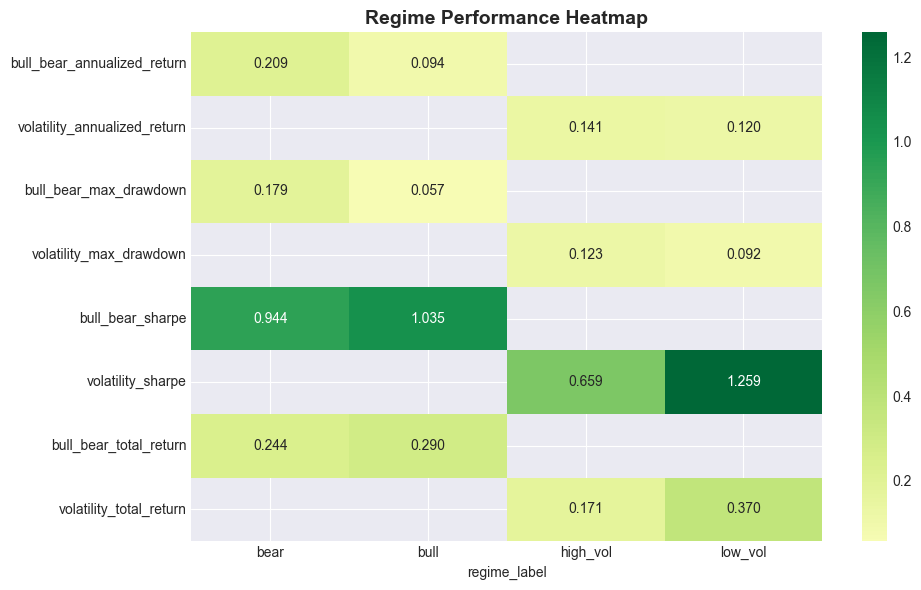

Saved regime heatmap to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_heatmap.png

Regime Performance Table:
              bull_bear_annualized_return  volatility_annualized_return  bull_bear_max_drawdown  volatility_max_drawdown  bull_bear_sharpe  volatility_sharpe  bull_bear_total_return  volatility_total_return
regime_label                                                                                                                                                                                                  
bear                             0.209316                           NaN                0.179224                      NaN          0.943773                NaN                0.244476                      NaN
bull                             0.093776                           NaN                0.057106                      NaN          1.034820                NaN                0.289590                      NaN
high_vol                              NaN         

In [17]:
# Create heatmap of regime performance
if regime_df is not None:
    pivot_df = regime_df.pivot_table(
        index='regime_label', 
        columns='regime_type', 
        values=['total_return', 'annualized_return', 'sharpe', 'max_drawdown'],
        aggfunc='first'
    )
    
    # Flatten column names
    pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_df.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=ax)
    ax.set_title('Regime Performance Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "regime_heatmap.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved regime heatmap to {EXPORTS_DIR / 'regime_heatmap.png'}")
    
    print("\nRegime Performance Table:")
    print(pivot_df.to_string())


In [18]:
# Export regime analysis tables and summary statistics
if regime_df is not None:
    # Export main comparison table
    export_table_csv(regime_df, EXPORTS_DIR / "regime_comparison_analysis.csv")
    export_table_latex(regime_df, EXPORTS_DIR / "regime_comparison_analysis.tex", float_format="%.4f")
    export_table_html(regime_df, EXPORTS_DIR / "regime_comparison_analysis.html", classes='table table-striped')
    
    # Export separate tables for each regime type
    bull_bear_df = regime_df[regime_df['regime_type'] == 'bull_bear']
    vol_df = regime_df[regime_df['regime_type'] == 'volatility']
    
    if not bull_bear_df.empty:
        export_table_csv(bull_bear_df, EXPORTS_DIR / "regime_bull_bear.csv")
        export_table_latex(bull_bear_df, EXPORTS_DIR / "regime_bull_bear.tex", float_format="%.4f")
    
    if not vol_df.empty:
        export_table_csv(vol_df, EXPORTS_DIR / "regime_volatility.csv")
        export_table_latex(vol_df, EXPORTS_DIR / "regime_volatility.tex", float_format="%.4f")
    
    # Summary statistics
    print("\n=== Regime Performance Summary ===\n")
    
    # Bull/Bear summary
    if not bull_bear_df.empty:
        print("Bull/Bear Regimes:")
        print(f"  Best Sharpe: {bull_bear_df.loc[bull_bear_df['sharpe'].idxmax(), 'regime_label']} ({bull_bear_df['sharpe'].max():.4f})")
        print(f"  Best Return: {bull_bear_df.loc[bull_bear_df['total_return'].idxmax(), 'regime_label']} ({bull_bear_df['total_return'].max():.4f})")
        print(f"  Lowest Drawdown: {bull_bear_df.loc[bull_bear_df['max_drawdown'].idxmin(), 'regime_label']} ({bull_bear_df['max_drawdown'].min():.4f})")
        print()
    
    # Volatility summary
    if not vol_df.empty:
        print("Volatility Regimes:")
        print(f"  Best Sharpe: {vol_df.loc[vol_df['sharpe'].idxmax(), 'regime_label']} ({vol_df['sharpe'].max():.4f})")
        print(f"  Best Return: {vol_df.loc[vol_df['total_return'].idxmax(), 'regime_label']} ({vol_df['total_return'].max():.4f})")
        print(f"  Lowest Drawdown: {vol_df.loc[vol_df['max_drawdown'].idxmin(), 'regime_label']} ({vol_df['max_drawdown'].min():.4f})")
        print()
    
    # Overall best
    best_overall = regime_df.loc[regime_df['sharpe'].idxmax()]
    print(f"Overall Best Regime: {best_overall['regime_type']} - {best_overall['regime_label']}")
    print(f"  Sharpe: {best_overall['sharpe']:.4f}")
    print(f"  Total Return: {best_overall['total_return']:.4f}")
    print(f"  Max Drawdown: {best_overall['max_drawdown']:.4f}")


Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_comparison_analysis.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_comparison_analysis.tex
Exported HTML table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_comparison_analysis.html
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_bull_bear.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_bull_bear.tex
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_volatility.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/regime_volatility.tex

=== Regime Performance Summary ===

Bull/Bear Regimes:
  Best Sharpe: bull (1.0348)
  Best Return: bull (0.2896)
  Lowest Drawdown: bull (0.0571)

Volatility Regimes:
  Best Sharpe: low_vol (1.2588)
  Best Return: low_vol (0.3702)
  Lowest Drawdown: low_vol (0.0915)

Overall Best Regime: volatility - low_

## 5. Reward Shaping Analysis

Compare performance across different reward shaping configurations: transaction costs, risk penalties, and drawdown guards.


In [21]:
# Load reward shaping results
reward_shaping_dir = RESULTS_DIR / "reward_shaping"
reward_shaping_data = []

for json_file in reward_shaping_dir.glob("*_metrics.json"):
    with open(json_file, 'r') as f:
        metrics = json.load(f)
        name = json_file.stem.replace("_metrics", "")
        row = {"config": name}
        
        # Extract shaping config details
        if 'shaping_config' in metrics:
            shaping_cfg = metrics['shaping_config']
            row['transaction_cost'] = shaping_cfg.get('transaction_cost', 0.0)
            row['lambda_risk'] = shaping_cfg.get('lambda_risk', 0.0)
            row['lambda_drawdown'] = shaping_cfg.get('lambda_drawdown', 0.0)
        
        # Add metrics (excluding shaping_config)
        row['total_return'] = metrics.get('total_return', float('nan'))
        row['annualized_return'] = metrics.get('annualized_return', float('nan'))
        row['sharpe'] = metrics.get('sharpe', float('nan'))
        row['max_drawdown'] = metrics.get('max_drawdown', float('nan'))
        
        reward_shaping_data.append(row)

if reward_shaping_data:
    reward_shaping_df = pd.DataFrame(reward_shaping_data)
    print("Reward Shaping Results:")
    print(reward_shaping_df.to_string(index=False))
else:
    print("Reward shaping results not found")
    reward_shaping_df = None


Reward Shaping Results:
        config  transaction_cost  lambda_risk  lambda_drawdown  total_return  annualized_return    sharpe  max_drawdown
     high_cost             0.002          0.0              0.0     -0.419412          -0.127449 -2.182255      0.419921
    no_shaping             0.000          0.0              0.0     -0.148349          -0.039465 -0.192694      0.369770
drawdown_guard             0.000          0.0              0.5     -1.000000          -1.000000 -1.162387      1.000000
  risk_penalty             0.000          0.2              0.0     -0.002548          -0.000639 -0.003264      0.335208


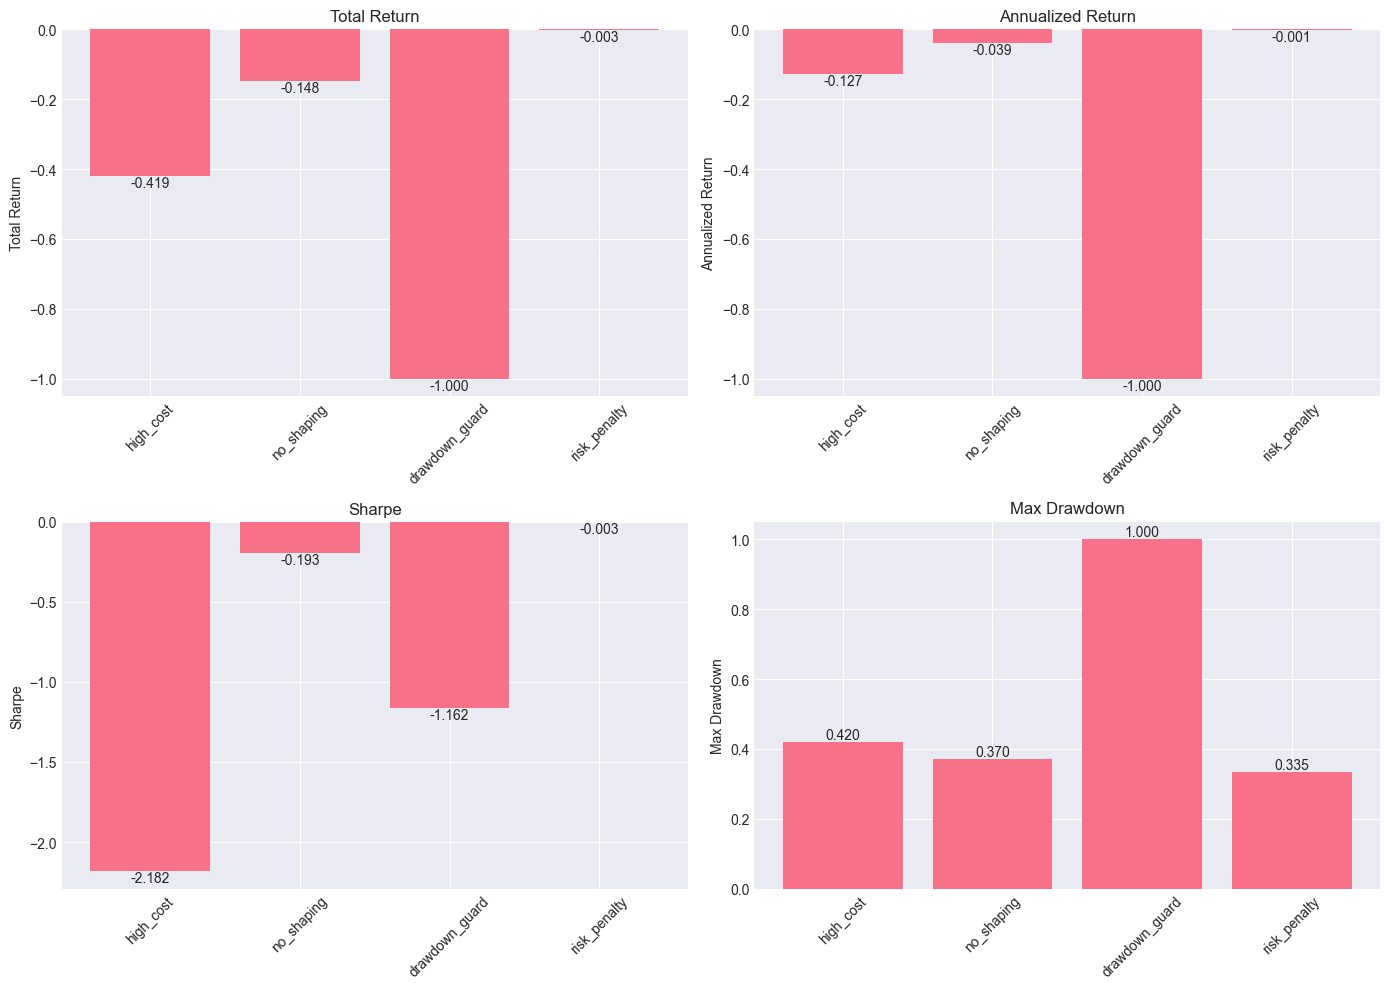

Saved reward shaping comparison plot to /Users/nickdonato/finm-rl-project/notebooks/exports/reward_shaping_comparison.png


In [22]:
# Visualize reward shaping comparison
if reward_shaping_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(reward_shaping_df['config'], reward_shaping_df[metric])
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "reward_shaping_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved reward shaping comparison plot to {EXPORTS_DIR / 'reward_shaping_comparison.png'}")


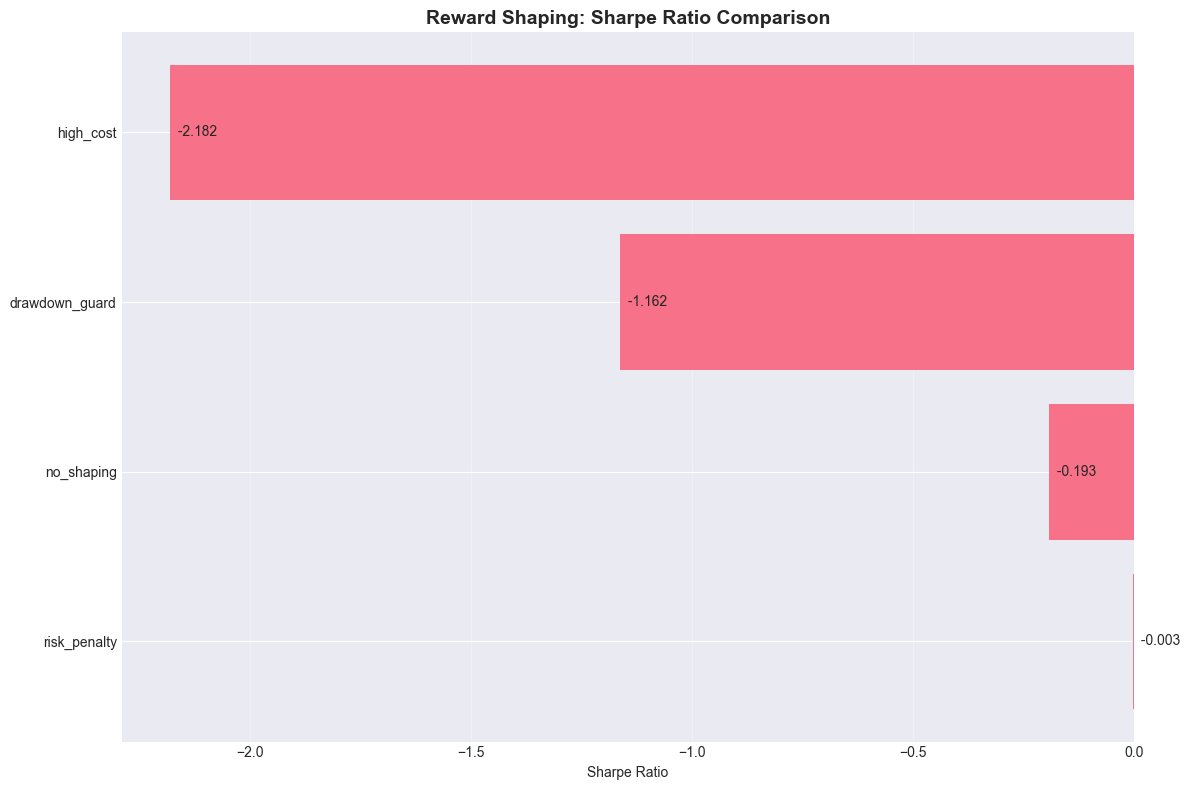

Saved reward shaping Sharpe comparison to /Users/nickdonato/finm-rl-project/notebooks/exports/reward_shaping_sharpe_comparison.png

Best Reward Shaping Configuration (by Sharpe):
config               risk_penalty
transaction_cost              0.0
lambda_risk                   0.2
lambda_drawdown               0.0
total_return            -0.002548
annualized_return       -0.000639
sharpe                  -0.003264
max_drawdown             0.335208
Name: 3, dtype: object


In [23]:
# Plot all reward shaping equity curves together
if reward_shaping_df is not None:
    from eval.plotting import plot_equity_curves
    import pandas as pd
    
    # Load equity curves from individual PNG files would require image processing
    # Instead, we'll note that individual equity plots are available in results/reward_shaping/
    # For a combined plot, you would need to modify exp_reward_shaping.py to save equity arrays
    # For now, we'll create a comparison based on metrics
    
    # Create a comparison showing the impact of each shaping type
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sort by sharpe for better visualization
    reward_shaping_sorted = reward_shaping_df.sort_values('sharpe', ascending=False)
    
    x_pos = np.arange(len(reward_shaping_sorted))
    bars = ax.barh(x_pos, reward_shaping_sorted['sharpe'])
    ax.set_yticks(x_pos)
    ax.set_yticklabels(reward_shaping_sorted['config'])
    ax.set_xlabel('Sharpe Ratio')
    ax.set_title('Reward Shaping: Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (idx, row) in enumerate(reward_shaping_sorted.iterrows()):
        ax.text(row['sharpe'], i, f"  {row['sharpe']:.3f}", 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(EXPORTS_DIR / "reward_shaping_sharpe_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved reward shaping Sharpe comparison to {EXPORTS_DIR / 'reward_shaping_sharpe_comparison.png'}")
    
    print("\nBest Reward Shaping Configuration (by Sharpe):")
    best_shaping = reward_shaping_df.loc[reward_shaping_df['sharpe'].idxmax()]
    print(best_shaping)


In [24]:
# Export reward shaping tables
if reward_shaping_df is not None:
    export_table_csv(reward_shaping_df, EXPORTS_DIR / "reward_shaping_comparison.csv")
    export_table_latex(reward_shaping_df, EXPORTS_DIR / "reward_shaping_comparison.tex", float_format="%.4f")
    export_table_html(reward_shaping_df, EXPORTS_DIR / "reward_shaping_comparison.html", classes='table table-striped')
    
    # Summary of shaping impact
    print("\n=== Reward Shaping Impact Summary ===\n")
    no_shaping = reward_shaping_df[reward_shaping_df['config'] == 'no_shaping']
    if not no_shaping.empty:
        baseline_sharpe = no_shaping.iloc[0]['sharpe']
        baseline_return = no_shaping.iloc[0]['total_return']
        print(f"Baseline (no shaping): Sharpe={baseline_sharpe:.4f}, Return={baseline_return:.4f}\n")
        
        for _, row in reward_shaping_df.iterrows():
            if row['config'] != 'no_shaping':
                sharpe_diff = row['sharpe'] - baseline_sharpe
                return_diff = row['total_return'] - baseline_return
                print(f"{row['config']}:")
                print(f"  Sharpe change: {sharpe_diff:+.4f} ({sharpe_diff/baseline_sharpe*100:+.1f}%)")
                print(f"  Return change: {return_diff:+.4f} ({return_diff/baseline_return*100:+.1f}%)")
                print(f"  Config: cost={row['transaction_cost']}, risk={row['lambda_risk']}, drawdown={row['lambda_drawdown']}")
                print()


Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/reward_shaping_comparison.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/reward_shaping_comparison.tex
Exported HTML table to /Users/nickdonato/finm-rl-project/notebooks/exports/reward_shaping_comparison.html

=== Reward Shaping Impact Summary ===

Baseline (no shaping): Sharpe=-0.1927, Return=-0.1483

high_cost:
  Sharpe change: -1.9896 (+1032.5%)
  Return change: -0.2711 (+182.7%)
  Config: cost=0.002, risk=0.0, drawdown=0.0

drawdown_guard:
  Sharpe change: -0.9697 (+503.2%)
  Return change: -0.8517 (+574.1%)
  Config: cost=0.0, risk=0.0, drawdown=0.5

risk_penalty:
  Sharpe change: +0.1894 (-98.3%)
  Return change: +0.1458 (-98.3%)
  Config: cost=0.0, risk=0.2, drawdown=0.0



## 6. Robustness Analysis


## 6. Robustness Analysis


Robustness Summary (per run):
        name  total_return  annualized_return    sharpe  max_drawdown
                       NaN                NaN       NaN           NaN
                       NaN                NaN       NaN           NaN
  seed_0_pre      0.080632           0.019635  0.087113      0.492281
  seed_1_pre      1.324891           0.235589  1.046673      0.233656
                       NaN                NaN       NaN           NaN
seed_3_nopre      0.221149           0.051373  0.337120      0.217320
                       NaN                NaN       NaN           NaN
                       NaN                NaN       NaN           NaN
                       NaN                NaN       NaN           NaN
                       NaN                NaN       NaN           NaN
seed_1_nopre     -0.162817          -0.043583 -0.222309      0.370120
seed_4_nopre      0.005024           0.001257  0.007201      0.325302
                       NaN                NaN       NaN     

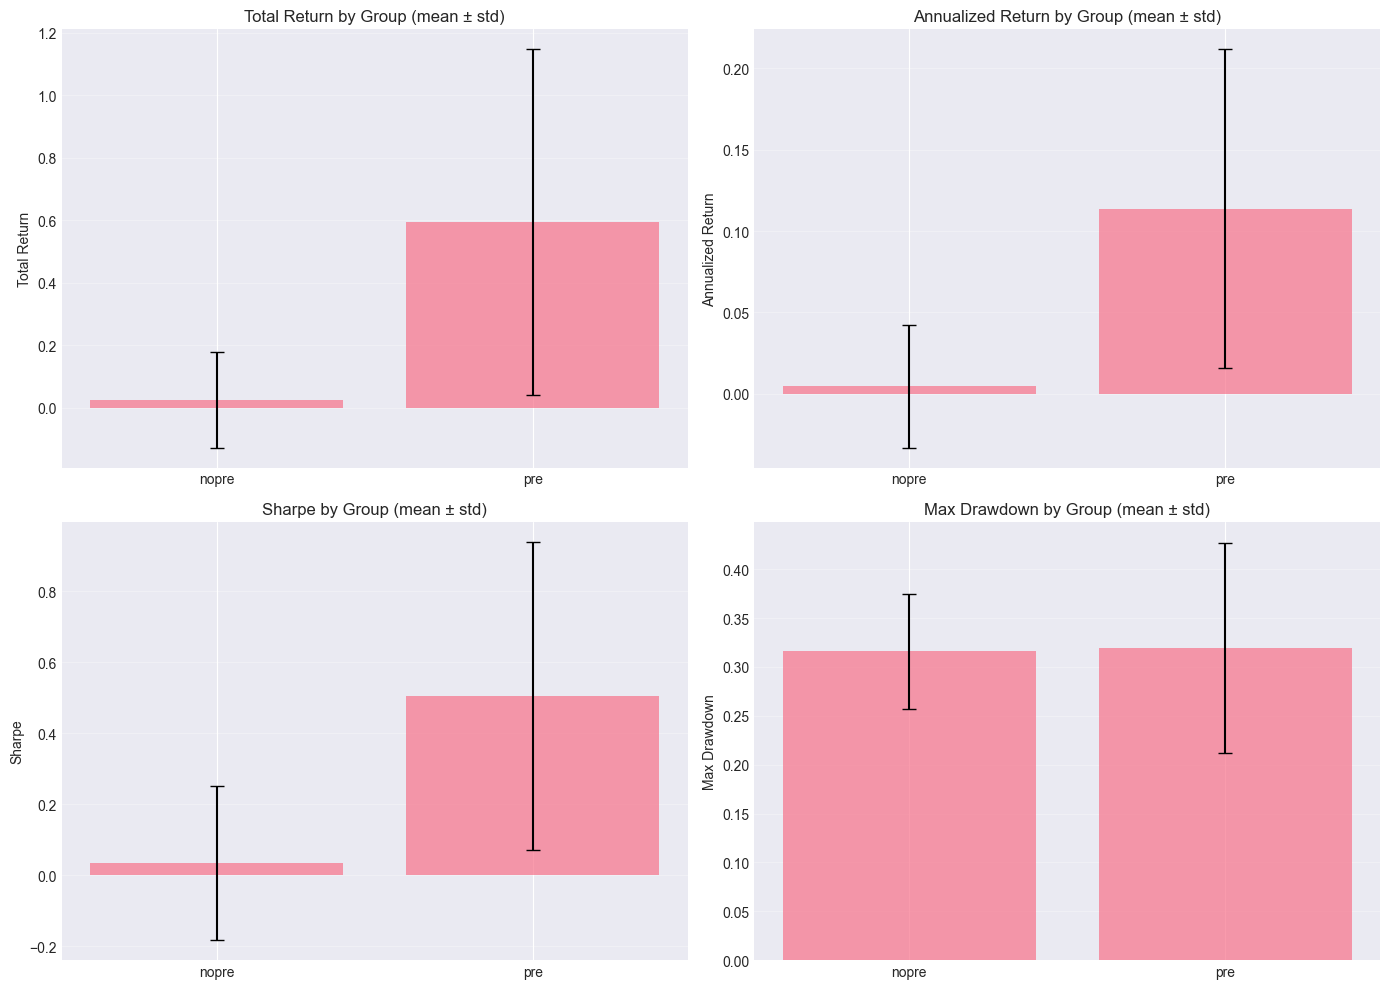

Saved robustness comparison plot to /Users/nickdonato/finm-rl-project/notebooks/exports/robustness_comparison.png
Exported table to /Users/nickdonato/finm-rl-project/notebooks/exports/robustness_group_stats.csv
Exported LaTeX table to /Users/nickdonato/finm-rl-project/notebooks/exports/robustness_group_stats.tex


In [19]:
# Load robustness results
robustness_dir = RESULTS_DIR / "ppo_seed_pretrain_compare"
robustness_summary_path = robustness_dir / "summary_test_metrics.csv"
robustness_group_stats_path = robustness_dir / "summary_group_stats.csv"

if robustness_summary_path.exists():
    from eval.summarize import summarize_runs
    
    # Load individual run JSONs
    run_payloads = []
    for json_file in robustness_dir.glob("*.json"):
        if json_file.name not in ["summary_test_metrics.json"]:
            with open(json_file, 'r') as f:
                run_payloads.append(json.load(f))
    
    if run_payloads:
        robustness_df = summarize_runs(run_payloads, metric_key="test_metrics")
        print("Robustness Summary (per run):")
        print(robustness_df.to_string(index=False))
        
        # Load group statistics
        if robustness_group_stats_path.exists():
            group_stats_df = pd.read_csv(robustness_group_stats_path)
            print("\nGroup Statistics (mean/std by pretrained vs non-pretrained):")
            print(group_stats_df.to_string(index=False))
            
            # Visualize group statistics
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            metrics = ['total_return', 'annualized_return', 'sharpe', 'max_drawdown']
            
            for idx, metric in enumerate(metrics):
                ax = axes[idx // 2, idx % 2]
                metric_data = group_stats_df[group_stats_df['metric'] == metric]
                
                groups = metric_data['group'].unique()
                means = [metric_data[metric_data['group'] == g]['mean'].values[0] for g in groups]
                stds = [metric_data[metric_data['group'] == g]['std'].values[0] for g in groups]
                
                x_pos = np.arange(len(groups))
                bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
                ax.set_xticks(x_pos)
                ax.set_xticklabels(groups)
                ax.set_ylabel(metric.replace("_", " ").title())
                ax.set_title(f'{metric.replace("_", " ").title()} by Group (mean ± std)')
                ax.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.savefig(EXPORTS_DIR / "robustness_comparison.png", dpi=150, bbox_inches='tight')
            plt.show()
            print(f"Saved robustness comparison plot to {EXPORTS_DIR / 'robustness_comparison.png'}")
            
            # Export tables
            export_table_csv(group_stats_df, EXPORTS_DIR / "robustness_group_stats.csv")
            export_table_latex(group_stats_df, EXPORTS_DIR / "robustness_group_stats.tex", float_format="%.4f")
    else:
        print("No robustness run data found")
        robustness_df = None
        group_stats_df = None
else:
    print("Robustness results not found")
    robustness_df = None
    group_stats_df = None
